# Analyzing clusters of RefSeq, known_knowns, and known_unknowns

Contigs that have at least 50% sequence identity were clustered using MMSeq2. This notebook further analyzed the results to find trends related to size of clusters, lengths of sequences in cluster, taxonomy, etc.

In [1]:
# importing pandas for table manipulations and seaborn for plotting
import pandas as pd
import seaborn as sns

### 1 MMseq2
MMseq2 clusters were generated using:

```
$
```

Commas were removed from the sequence names

```
$sed 's/,/_/g' tests/data/kk_ku_ref_outDB2.tsv > tests/data/kk_ku_ref_outDB2_nocomma.tsv

```


In [2]:
cl_table = pd.read_csv("tests/data/kk_ku_ref_outDB2_nocomma.tsv", sep="\t", header=None)
cl_table.head()

,0,1
0,SRR4289238_Contig_5_56.1231:1.1263,SRR4289238_Contig_5_56.1231:1.1263
1,SRR4289238_Contig_5_56.1231:1.1263,NC_006259.1
2,SRR4032596_Contig_412_239.073:1.6376,SRR4032596_Contig_412_239.073:1.6376
3,SRR4032596_Contig_412_239.073:1.6376,NC_001609.1
4,SRR4032596_Contig_412_239.073:1.6376,SRR7524180_Contig_2887_4.15617:1.8613


Number of clusters detected using mmseq2 for 21,484 (`kk_ku_ref.fasta`) sequences (RefSeq viruses and > 50% identity) = 13,173

In [3]:
# group by the reference cluster name and then converting its members to a list
gp_table = cl_table.groupby(0)[1].apply(list)
all_cl_table = pd.DataFrame(gp_table)
all_cl_table.shape
#all_cl_table.head()


(13173, 1)

In [4]:
# from list to rows
all_cl_df = pd.DataFrame(all_cl_table[1].apply(pd.Series).stack())
all_cl_df.columns = ["members"]
all_cl_df.tail(5)

members
0                                                                            
SRR953964_Contig_33_23.3381:1.5770 42  SRR3726368_Contig_15701_7.83611:1.1820
                                   43   SRR7524167_Contig_8081_78.9699:1.1083
                                   44    SRR4101321_Contig_163_122.181:1.1476
                                   45   SRR3132198_Contig_4756_6.33391:1.1170
                                   46    SRR1161348_Contig_287_15.1867:1.1059

In [5]:
# Distribution of cluster size
cl_size = pd.DataFrame(all_cl_df.groupby(0).apply(len))
cl_size.columns = ["size"]
cl_size.head()


,size
0,
AC_000001.1,2
AC_000002.1,2
AC_000003.1,2
AC_000005.1,2
AC_000007.1,4


/Users/migunshakya/miniconda3/envs/mash/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'proportion of clusters'), Text(0.5,0,'Cluster sizes')]

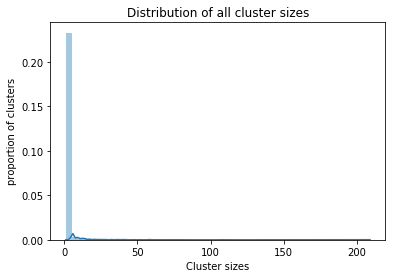

In [6]:
dp = sns.distplot(cl_size['size'].tolist())
dp.set_title('Distribution of all cluster sizes')
dp.set(xlabel='Cluster sizes', ylabel='proportion of clusters')

76

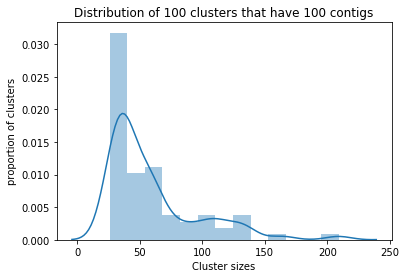

In [7]:
dp = sns.distplot(cl_size[cl_size['size'] > 25]['size'].tolist())
dp.set_title('Distribution of 100 clusters that have 100 contigs')
dp.set(xlabel='Cluster sizes', ylabel='proportion of clusters')
len(cl_size[cl_size['size'] > 25]['size'].tolist())

13094

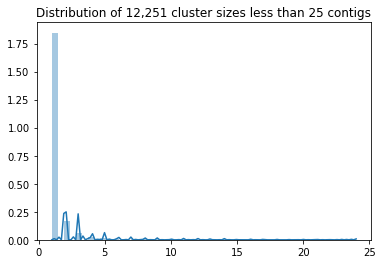

In [8]:
dp = sns.distplot(cl_size[cl_size['size'] < 25]['size'].tolist())
dp.set_title('Distribution of 12,251 cluster sizes less than 25 contigs')
len(cl_size[cl_size['size'] < 25]['size'].tolist())

remove commas from fai file as well
```
$ sed 's/,/_/g' tests/data/kk_ku_ref.fasta.fai > tests/data/kk_ku_ref_nocomma.fasta.fai
```

In [9]:
# read in fai file generated using samtools to get sequence length of each sequence
len_table = pd.read_csv("tests/data/kk_ku_ref_nocomma.fasta.fai",
                        sep="\t", header=None, index_col=0, names=["length", "A", "B", "C"])
len_table = len_table.drop(columns=["A", "B", "C"])
len_table.tail()

,length
NC_038551.1,285
NC_038552.1,285
NC_004033.1,230
NC_003380.1,220
NC_002566.1,200


In [10]:
# convert length table to dictionary object
len_dict=len_table.to_dict()

In [11]:
# replace name with length of contigs in each cluster
length_info = all_cl_df.replace(len_dict['length'])
length_info.head()

members
0                    
AC_000001.1 0   33034
            1   33034
AC_000002.1 0   34446
            1   34446
AC_000003.1 0   30536

In [12]:

len_only = length_info.convert_objects(convert_numeric=True).dropna()
len_only.head()



/Users/migunshakya/miniconda3/envs/mash/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


members
0                     
AC_000001.1 0  33034.0
            1  33034.0
AC_000002.1 0  34446.0
            1  34446.0
AC_000003.1 0  30536.0

In [13]:
length_info_reset = len_only.reset_index()
length_info_final = length_info_reset.drop(["level_1"], axis=1)
length_info_final.head()



,0,members
0,AC_000001.1,33034.0
1,AC_000001.1,33034.0
2,AC_000002.1,34446.0
3,AC_000002.1,34446.0
4,AC_000003.1,30536.0


In [14]:


len_std = pd.DataFrame(length_info_final.groupby(0)["members"].std().dropna())
len_std[len_std['members'] > 0].head()




,members
0,
AC_000007.1,31.836824
DRR072200_Contig_305_5.99897:1.2923,676.626559
DRR072200_Contig_403_6.35847:1.1585,339.595066
ERR1121418_ERR1121418.AF144301.1:1.2341,24.099793
ERR1121418_ERR1121418.AF144304.1:1.1458,27.712813


Text(0.5,1,'Distribution of SD of lengths within each cluster for 488')

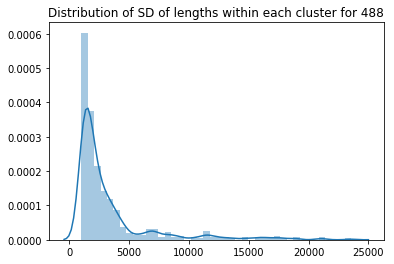

In [15]:
dx = sns.distplot(len_std[len_std['members'] > 1000]['members'].tolist())
dx.set_title("Distribution of SD of lengths within each cluster for %s" % (len(len_std[len_std['members'] > 1000]['members'])))

In [16]:
singletons = all_cl_df.groupby(0).filter(lambda x:len(x["members"].tolist()) == 1)
singletons.head(10)
singletons.tail(10)
singletons.shape

(11120, 1)

In [18]:
# number of clusters that have more than 1 contig
non_singletons = all_cl_df.groupby(0).filter(lambda x:len(x["members"].tolist()) > 1)
non_singletons.head(10)
non_singletons.tail(10)
len(set(non_singletons.reset_index()[0].tolist()))

2053

In [19]:
non_singletons

members
0                                                                             
AC_000001.1                         0                              AC_000001.1
                                    1                              NC_002513.1
AC_000002.1                         0                              AC_000002.1
                                    1                              NC_001876.1
AC_000003.1                         0                              AC_000003.1
                                    1                              NC_001734.1
AC_000005.1                         0                              AC_000005.1
                                    1                              NC_001460.1
AC_000007.1                         0                              AC_000007.1
                                    1                              NC_001405.1
                                    2                              AC_000017.1
                                    3                              AC_000008.1
DRR072200_Contig_305_5.99897:1.2923 0      DRR072200_Contig_305_5.99897:1.2923
                                    1   ERR1543987_Contig_42791_6.00154:1.2611
                                    2    ERR1600431_Contig_1498_15.8361:1.2222
                                    3   SRR4435956_Contig_19143_9.30264:1.1649
                                    4    ERR2029933_Contig_2957_25.7984:1.1568
                                    5     SRR3132158_Contig_2024_5.6175:1.1037
                                    6     SRR5431717_Contig_728_97.8413:1.1488
                                    7    SRR3131996_Contig_1772_9.06759:1.1174
                                    8     SRR3131990_Contig_184_5.13649:1.1141
DRR072200_Contig_403_6.35847:1.1585 0      DRR072200_Contig_403_6.35847:1.1585
                                    1   ERR2749899_Contig_10996_7.43491:1.2701
                                    2     ERR970331_Contig_1452_15.9596:1.2397
                                    3    SRR7524151_Contig_1171_9.36634:1.2171
                                    4     SRR7524166_Contig_2089_12.504:1.1278
                                    5     SRR6659544_Contig_117_51.5674:1.2112
                                    6    SRR5165961_Contig_4714_19.3796:1.2536
                                    7     SRR6659448_Contig_191_135.176:1.2072
                                    8     SRR6659539_Contig_139_83.7115:1.2072
...                                                                        ...
SRR953964_Contig_33_23.3381:1.5770  17    SRR1160905_Contig_255_13.6843:1.1743
                                    18   SRR4101320_Contig_3211_156.451:1.1147
                                    19  SRR5165851_Contig_43740_8.05612:1.2176
                                    20    DRR072200_Contig_2864_6.82552:1.2003
                                    21  SRR1491039_Contig_23985_5.49675:1.1864
                                    22    SRR1160732_Contig_178_13.2519:1.1687
                                    23    SRR4101312_Contig_171_153.549:1.1476
                                    24      SRR4101321_Contig_68_132.45:1.1397
                                    25   SRR7125628_Contig_2818_4.05681:1.1393
                                    26    SRR4101289_Contig_143_215.842:1.1393
                                    27   SRR1917928_Contig_4993_5.71385:1.1341
                                    28   SRR3132288_Contig_2126_5.72369:1.1341
                                    29    SRR4101289_Contig_156_251.998:1.1321
                                    30   SRR7524151_Contig_3319_8.51806:1.1958
                                    31    SRR3131781_Contig_386_4.53976:1.2095
                                    32   SRR3132298_Contig_2514_6.26078:1.1968
                                    33    SRR1145912_Contig_9015_40.094:1.1573
                                    34  SRR5091499_Contig_18019_14.1849:1.2773
                                    35   S

In [20]:
# singletons that have RefSeq
NC_genomes_sing=singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist())).reset_index()[0].tolist()
NC_genom_sing = [x[:-2] for x in NC_genomes_sing]
len(set(NC_genom_sing))


8333

In [22]:
singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist()))

,,members
0,,
NC_000852.5_0,0,NC_000852.5_0
NC_000852.5_1,0,NC_000852.5_1
NC_000852.5_2,0,NC_000852.5_2
NC_000852.5_3,0,NC_000852.5_3
NC_000852.5_4,0,NC_000852.5_4
NC_000852.5_5,0,NC_000852.5_5
NC_000855.1,0,NC_000855.1
NC_000858.1,0,NC_000858.1
NC_000866.4_2,0,NC_000866.4_2


In [23]:
# non singletons that have RefSeq
NC_genomes_nosing=non_singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist())).reset_index()[0].tolist()
NC_genom_nosing = [x[:-2] for x in NC_genomes_nosing]
len(set(NC_genom_nosing))

1013

In [24]:
novel_genomes_nosing=non_singletons.groupby(0).filter(lambda x: 'NC_' not in ''.join(x['members'].tolist())).reset_index()[0].tolist()
nonNC_genom_nosing = [x[:-2] for x in novel_genomes_nosing]
len(set(nonNC_genom_nosing))


998

|Title|numbers|
| ------------------------- | ------ |
| # of clusters             | 13,173 |
| # of singleton clusters   | 11,120 |
| # of non-singleton clusters  | 2,053 |
| # of singleton refseq-clusters  | 8,333 |
| # of non-singleton that have refseq-clusters  | 1,013 |
| # of non-singleton that have no refseq-clusters  | 998 |



# Analyzing blast clusters